<img src=https://i.postimg.cc/vZHWS7dF/337576533386.jpg, width=600>

# 빅데이터와 증권사 잔고 분석

# 📈 증권 잔고 빅데이터 분석: 자산 흐름의 패턴과 규칙 발견

### 1. 배경: 거대한 데이터 속의 질서
현대 금융 시장은 매일 수백만 건의 거래와 잔고 변화가 발생하는 빅데이터의 집합체입니다. 단순히 개별 종목의 가격 변화를 보는 것을 넘어, 증권사 내부의 방대한 잔고 데이터를 분석하는 것은 시장의 실질적인 자금 흐름과 투자자들의 집단적 움직임을 파악할 수 있는 가장 강력한 방법입니다. 100만 건이 넘는 대규모 잔고 데이터를 처리하고 분석하는 과정은 단순한 통계를 넘어, 금융 시장의 생태계를 이해하는 기초가 됩니다.

### 2. 빅데이터 분석의 가치와 도전
본 분석에서 다루는 1,011,732행의 데이터는 시간(Date), 팀(Team), 종목(Ticker), 자산 유형(Type), 가격(Price) 등 다차원적인 정보를 담고 있습니다. 이러한 대규모 데이터를 다룰 때는 단순한 조회를 넘어 데이터 처리의 효율성이 무엇보다 중요합니다. 우리는 이 방대한 로우(Row) 데이터들을 집계하고 가공하여, 개별 숫자가 아닌 '자산의 파동'을 찾아내는 과정에 집중할 것입니다.

### 3. 분석의 목적
본 노트북에서는 2023년 상반기 증권 잔고 데이터를 활용하여 자산 관리의 전략적 통찰을 도출합니다.

* **일자별 자산 총액 추이**: 전체 잔고의 합계를 일별로 집계하여 시장의 자금이 유입되는 시점과 유출되는 시점의 거시적 흐름을 파악합니다.
* **분기별 패턴 동기화 확인**: 분기마다 특정 시점(예: 분기 시작 후 n일차)에 잔고 합계의 변동 양상이 비슷하게 반복되는지 분석합니다. 이를 통해 금융 시장 특유의 계절성과 주기적 패턴을 발견합니다.
* **빅데이터 처리 역량**: 100만 건 이상의 데이터를 효율적으로 그룹화(Groupby)하고 시계열로 변환하는 과정을 통해 대용량 금융 데이터를 다루는 분석 프로세스를 정립합니다.

> **"파편화된 데이터는 정보에 불과하지만, 집계된 데이터는 전략이 된다."**


## 1. 데이터 프레임 불러오기

In [1]:
# 코드 1. 증권사 잔고 데이터에서 데이터 프레임 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.options.display.max_rows = 6 # 6행까지만 출력
pd.options.display.float_format = '{:.2f}'.format # 소수점 둘째 자리 출력
url = 'https://github.com/panda-kim/book1/blob/main/31secfirm02.csv?raw=true'
cols = ['Date', 'Team', 'Ticker', 'Type', 'Price(KRW)'] # 필요한 열만 지정
df = pd.read_csv(url, encoding='cp949', usecols=cols, parse_dates=['Date'])
df

,Date,Team,Ticker,Type,Price(KRW)
0,2023-01-01,TM1,R100,S,671
1,2023-01-01,TM1,R100,S,265
2,2023-01-01,TM1,R100,S,132
...,...,...,...,...,...
1011729,2023-06-30,TM4,W732,B,63
1011730,2023-06-30,TM4,W733,B,65
1011731,2023-06-30,TM4,W734,B,62


🔍 증권 잔고 데이터 컬럼 명세 (Data Dictionary)

본 데이터셋은 100만 행 이상의 대규모 금융 데이터로, 특정 기간 동안의 자산 변동과 팀별 운용 현황을 담고 있습니다.

### 1. 시간 및 식별 지표
* **Date (일자)**: 잔고가 기록된 날짜입니다.
    * *분석 포인트*: 분기별 패턴 분석을 위해 `datetime` 형변환 후 '분기(Quarter)' 및 '분기 내 경과일수(Day of Quarter)' 추출이 필수적입니다.
* **Team (운용팀)**: 자산을 운용하거나 관리하는 주체(팀)입니다.
    * *분석 포인트*: 범주형 데이터로, 팀별 자산 규모 차이나 분기별 목표 달성률을 비교하는 기준으로 활용됩니다.
* **Ticker (종목 코드)**: 주식, 채권 등 금융 상품의 고유 식별 코드입니다.

### 2. 자산 특성 및 수치 지표
* **Type (자산 유형)**: 자산의 종류를 구분하는 코드입니다. (예: S-주식, B-채권 등)
    * *분석 포인트*: 유형별 자산 비중 변화를 통해 시장 상황에 따른 포트폴리오의 변화를 추적할 수 있습니다.
* **Price (KRW, 잔고 금액)**: 해당 시점의 자산 평가 금액 또는 잔고 합계입니다.
    * *분석 포인트*: 본 EDA의 핵심 타겟 변수입니다. 일자별 합산($\sum$), 분기별 평균, 변동성(표준편차) 등을 계산하는 데 사용됩니다.

---

## 🛠 빅데이터 EDA를 위한 기술적 제언

100만 건이 넘는 행(Row)을 효율적으로 다루기 위해 다음의 데이터 탐색 과정을 추천합니다.

1. **메모리 최적화**:
   - `Team`, `Ticker`, `Type` 등 중복이 많은 문자열 컬럼은 `category` 타입으로 변환하여 메모리 점유율을 줄여야 합니다.
2. **시계열 집계 (Time-series Aggregation)**:
   - 일별 잔고 합계: `df.groupby('Date')['Price'].sum()`을 통해 전체 자산의 우상향/우하향 트렌드를 확인합니다.
3. **분기별 주기성(Seasonality) 분석**:
   - 각 분기별로 '1일차', '2일차' ... 'n일차'를 인덱싱하여, 서로 다른 분기의 자산 흐름을 하나의 그래프(Overlay)에 겹쳐 그려봅니다. 이를 통해 특정 분기마다 반복되는 패턴이 있는지 검증합니다.
4. **결측치 및 이상치 확인**:
   - 금융 데이터 특성상 가격이 `0`이거나 비정상적으로 큰 값이 있는지 `boxplot`이나 `describe()`를 통해 사전에 걸러내야 분석의 신뢰도를 확보할 수 있습니다.

## 2. 데이터 기본 정보 확인

In [2]:
# 코드 2. info 함수로 데이터 프레임 확인하기
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011732 entries, 0 to 1011731
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   Date        1011732 non-null  datetime64[ns]
 1   Team        1011732 non-null  object        
 2   Ticker      1011732 non-null  object        
 3   Type        1011732 non-null  object        
 4   Price(KRW)  1011732 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 38.6+ MB


결측값을 확인해야 하지만, info 함수 적용 결과 Null이 없기에 생략한다.

In [3]:
# 코드 3. df의 columns 확인하기
df.columns

Index(['Date', 'Team', 'Ticker', 'Type', 'Price(KRW)'], dtype='object')

In [4]:
# 코드 4. df의 기술 통계 확인하기
df.describe()

,Date,Price(KRW)
count,1011732,1011732.00
mean,2023-04-03 03:35:24.833058304,85.64
min,2023-01-01 00:00:00,-400.00
...,...,...
75%,2023-05-18 00:00:00,132.00
max,2023-06-30 00:00:00,2691.00
std,NaN,194.18


<Axes: ylabel='Price(KRW)'>

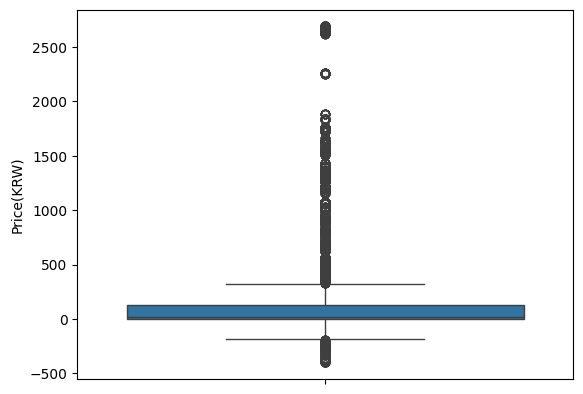

In [5]:
# 코드 5. 수치형 데이터를 표준화하여 박스 플롯 생성

sns.boxplot(df['Price(KRW)'])

In [6]:
# 코드 6. Team 열, Ticker 열, Type 열의 유일값 확인
print('Team: ', df['Team'].unique())
print('Ticker: ', df['Ticker'].unique())
print('Type: ', df['Type'].unique())

Team:  ['TM1' 'TM4' 'TM3' 'TM5' 'TM6' 'TM2']
Ticker:  ['R100' 'R101' 'R102' 'R103' 'R104' 'R110' 'R111' 'R112' 'R113' 'R114'
 'R120' 'R121' 'R122' 'R123' 'R124' 'R130' 'R131' 'R132' 'R133' 'R134'
 'R200' 'R201' 'R202' 'R203' 'R204' 'R210' 'R211' 'R212' 'R213' 'R214'
 'R220' 'R221' 'R222' 'R223' 'R224' 'R230' 'R231' 'R232' 'R233' 'R234'
 'R300' 'R301' 'R302' 'R303' 'R304' 'R310' 'R311' 'R312' 'R313' 'R314'
 'R320' 'R321' 'R322' 'R323' 'R324' 'R330' 'R331' 'R332' 'R333' 'R334'
 'R400' 'R401' 'R402' 'R403' 'R404' 'R410' 'R411' 'R412' 'R413' 'R414'
 'R420' 'R421' 'R422' 'R423' 'R424' 'R430' 'R431' 'R432' 'R433' 'R434'
 'R600' 'R601' 'R602' 'R603' 'R604' 'R610' 'R611' 'R612' 'R613' 'R614'
 'R620' 'R621' 'R622' 'R623' 'R624' 'R630' 'R631' 'R632' 'R633' 'R634'
 'R700' 'R701' 'R702' 'R703' 'R704' 'R710' 'R711' 'R712' 'R713' 'R714'
 'R720' 'R721' 'R722' 'R723' 'R724' 'R730' 'R731' 'R732' 'R733' 'R734'
 'I0' 'I1' 'I2' 'I3' 'I4' 'I300' 'I303' 'I321' 'I322' 'I330' 'I332' 'I334'
 'S601' 'S612' 'S61

3. 기간별 분석

In [7]:
# 코드 7. 특정 일자(2023-03-31)의 데이터 필터링
df[df['Date'].eq('2023-03-31')]

,Date,Team,Ticker,Type,Price(KRW)
478490,2023-03-31,TM1,R100,S,129
478491,2023-03-31,TM1,R100,S,133
478492,2023-03-31,TM1,R100,S,135
...,...,...,...,...,...
484061,2023-03-31,TM4,W734,B,65
484062,2023-03-31,TM4,W734,B,62
484063,2023-03-31,TM4,W734,B,131


In [8]:
# 코드 8. 특정 기간의 데이터 필터링
df[df['Date'].between('2023-02-01', '2023-02-06')]

,Date,Team,Ticker,Type,Price(KRW)
158962,2023-02-01,TM1,R100,S,134
158963,2023-02-01,TM1,R100,S,132
158964,2023-02-01,TM1,R100,S,537
...,...,...,...,...,...
191613,2023-02-06,TM4,W732,B,128
191614,2023-02-06,TM4,W733,B,59
191615,2023-02-06,TM4,W734,B,64


In [9]:
# 코드 9. 일자별, 팀별, 상품 유형별 잔고 집계(df_result로 지정)
df_result = (
    df.groupby(['Team', 'Type'])
      .resample('D', on='Date')['Price(KRW)'].sum()
      .unstack(1).swaplevel(0, 1).sort_index(level=0)
)
df_result

Type                  B         S
Date       Team                  
2023-01-01 TM1      NaN 256350.00
           TM3      NaN  33132.00
           TM4   399.00   5284.00
...                 ...       ...
2023-06-30 TM4  9581.00   4258.00
           TM5  1608.00  83201.00
           TM6      NaN  30833.00

[1085 rows x 2 columns]

In [10]:
# 코드 10. df_result에서 특정 일자(2023-03-31)의 데이터 필터링
df_result.loc['2023-03-31']

Type,B,S
Team,,
TM1,NaN,225832.00
TM2,NaN,59677.00
TM3,NaN,25096.00
TM4,10314.00,6515.00
TM5,1340.00,92821.00
TM6,NaN,43080.00


In [11]:
# 코드 11. 특정 두 시점의 팀별 잔고 변화
date1 = '2023-03-31'
date2 = '2023-06-30'
df_result.loc[date1].sub(df_result.loc[date2], fill_value=0)

Type,B,S
Team,,
TM1,NaN,-22029.00
TM2,NaN,-6891.00
TM3,NaN,9203.00
TM4,733.00,2257.00
TM5,-268.00,9620.00
TM6,NaN,12247.00


In [12]:
# 코드 12. 특정 기간의 팀별 잔고 집계(전체 집계 결과에서 인덱싱)
(df_result
 .loc['2023-02-01':'2023-02-06']
 .sum(axis=1).unstack().astype('int')
)

Team,TM1,TM2,TM3,TM4,TM5,TM6
Date,,,,,,
2023-02-01,235187,63352,49818,17814,90163,47583
2023-02-02,224894,60800,54397,18789,76711,44405
2023-02-03,255492,57359,49222,16809,82806,41870
2023-02-04,244184,59615,46064,18086,71938,53346
2023-02-05,249285,61033,47126,18442,70335,57485
2023-02-06,225854,62375,46651,19942,71774,51415


In [13]:
# 코드 13. 일자별 전체 잔고 집계
s = df.resample('D', on='Date')['Price(KRW)'].sum()
s

,Price(KRW)
Date,
2023-01-01,421327
2023-01-02,411415
2023-01-03,404047
...,...
2023-06-28,460625
2023-06-29,467692
2023-06-30,459803


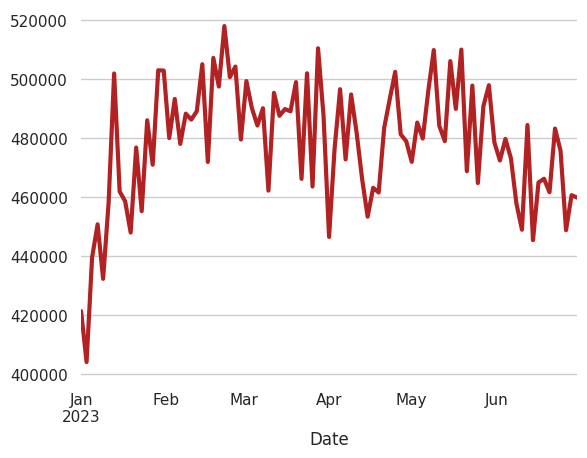

In [14]:
# 코드 14. 일자별 전체 잔고 시각화
# seaborn 라이브러리의 배경 테마를 white로 설정
sns.set_theme(style='white')

# 2일 기준으로 그래프 생성
ax = s[::2].plot(lw=3, color='firebrick')

# y축 눈금 생성
ax.grid(axis='y')

# 축 테두리 제거
sns.despine(bottom=True, left=True)

In [15]:
# 코드 15. 분기별로 시간의 흐름에 따라 전체 잔고 집계(그루퍼 사용)
grp1 = s.index.to_period('Q')
grp2 = s.groupby(grp1).cumcount()
df_quarter = s.groupby([grp1, grp2]).sum().unstack(0)
df_quarter

Date,2023Q1,2023Q2
0,421327.00,446471.00
1,411415.00,463520.00
2,404047.00,476356.00
...,...,...
88,487432.00,460625.00
89,464675.00,467692.00
90,NaN,459803.00


In [16]:
# 코드 16. 분기별로 시간의 흐름에 따라 전체 잔고 집계(열 생성)
df_quarter = s.reset_index()
df_quarter['Q'] = df_quarter['Date'].dt.to_period('Q')
df_quarter['D+'] = df_quarter.groupby('Q').cumcount()
df_quarter = (df_quarter
              .pivot(index='D+', columns='Q', values='Price(KRW)')
              .rename_axis(index='Date', columns=None)
)
df_quarter

,2023Q1,2023Q2
Date,,
0,421327.00,446471.00
1,411415.00,463520.00
2,404047.00,476356.00
...,...,...
88,487432.00,460625.00
89,464675.00,467692.00
90,NaN,459803.00


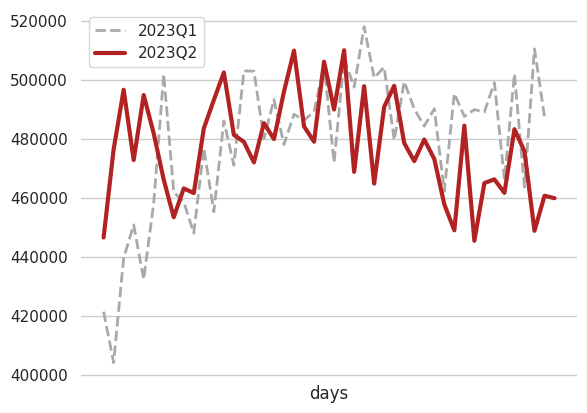

In [17]:
# 코드 17. 분기별로 시간에 흐름에 따라 전체 잔고 집계 결과 시각화

# 2023년 1분기 시각화
(df_quarter.loc[::2, '2023Q1']
 .plot(lw=2, ls='--', color='darkgrey', legend=True, grid=True, xticks=[])
)

# 2023년 2분기 시각화
(df_quarter.loc[::2, '2023Q2']
 .plot(lw=3, grid=True, legend=True, color='firebrick', xlabel='days')
)

# 축 테두리 제거
sns.despine(bottom=True, left=True)

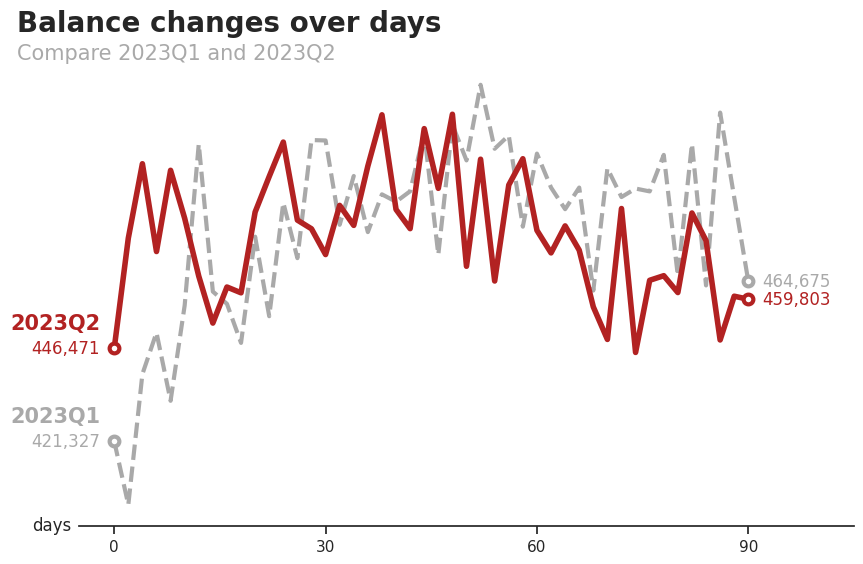

In [18]:
# 코드 18. 분기별로 시간에 흐름에 따라 전체 잔고 집계 시각화(2)

import seaborn as sns
import matplotlib.pyplot as plt

# seaborn 스타일 설정(ticks 테마)
sns.set_theme(style='ticks')

# 색상 변수 정의
c = ['darkgrey', 'firebrick']

# 2023년 1분기 데이터 추출 및 시각화
ax1 = df_quarter.ffill().loc[::2, '2023Q1'].plot(
    lw=3, ls='--', color=c[0], yticks=[], figsize=(10, 6),
    xlim=(-5, 105), xticks=[0, 30, 60, 90], xlabel=''
)

# 2023년 1분기 마지막 데이터 좌표 추출
x1, y1 = df_quarter.index[-1], df_quarter.ffill()['2023Q1'].iloc[-1]

# 간격을 변수로 설정
itv = 2

# 마커 및 텍스트 표시(2023년 1분기 끝)
plt.plot(x1, y1, marker='o', mfc='white', mec=c[0], ms=7, mew=3)
plt.text(x1 + itv, y1, f'{y1:,.0f}', color=c[0], size=12, va='center')

# 2023년 1분기 첫 데이터 좌표 추출
x2, y2 = df_quarter.index[0], df_quarter['2023Q1'].iloc[0]

# 마커 및 텍스트 표시(2023년 1분기 시작)
plt.plot(x2, y2, marker='o', mfc='white', mec=c[0], ms=7, mew=3)
plt.text(x2 - itv, y2, f'{y2:,.0f}', color=c[0], size=12,
         va='center', ha='right')

# 2023년 1분기 범례를 그래프 안에서 지칭
plt.text(x2 - itv, y2 + 5000, '2023Q1', color=c[0], weight='bold',
         size=15, ha='right')

# 2023년 2분기 데이터 시각화
df_quarter.loc[::2, '2023Q2'].plot(lw=4, color=c[1], xlabel='')

# 2023년 2분기 마지막 데이터 추출
y3 = df_quarter['2023Q2'].iloc[-1]

# 마커 및 텍스트 표시(2023년 2분기 끝)
plt.plot(x1, y3, marker='o', mfc='white', mec=c[1], ms=7, mew=3)
plt.text(x1 + itv, y3, f'{y3:,.0f}', color=c[1], size=12, va='center')

# 2023년 2분기 첫 데이터 추출
y4 = df_quarter['2023Q2'].iloc[0]

# 마커 및 텍스트 표시(2023년 2분기 시작)
plt.plot(x2, y4, 'o', mfc='white', mec=c[1], ms=7, mew=3)
plt.text(x2 - itv, y4, f'{y4:,.0f}', color=c[1], size=12,
         va='center', ha='right')

# 2023년 2분기 범례를 그래프 안에서 지칭
plt.text(x2 - itv, y4 + 5000, '2023Q2', color=c[1], weight='bold',
         size=15, ha='right')

# x축의 이름 지정
plt.text(-0.01, -0, 'days', transform=ax1.transAxes, size=12,
         va='center', ha='right')

# 제목과 소제목 지정
plt.text(-0.08, 1.07, 'Balance changes over days', size=20, weight='bold',
         transform=ax1.transAxes)

plt.text(-0.08, 1.01, 'Compare 2023Q1 and 2023Q2', color=c[0], size=15,
         transform=ax1.transAxes)

# 축 테두리 제거
sns.despine(left=True)

## 🏁 프로젝트 마무리: 데이터로 읽는 시장의 법칙

### 1. 100만 행의 빅데이터, 정보에서 통찰로
이번 분석은 1,011,732건이라는 방대한 증권사 잔고 데이터를 직접 다루며, 단순한 기록의 집합을 유의미한 비즈니스 통찰로 변환하는 과정을 경험했습니다. 대규모 데이터를 효율적으로 전처리하고 집계하는 과정을 통해, '빅데이터 분석'이 가진 강력한 힘을 체감할 수 있었습니다.

### 2. 분기별 추세 예측의 가능성 발견
특히 **'Balance changes over days'** 시각화 결과는 매우 고무적입니다.
* 2023년 1분기(Q1)와 2분기(Q2)의 잔고 변화 추이를 분기 내 경과일(Days) 기준으로 겹쳐 본 결과, 자산이 증감하는 특정 주기적 패턴을 확인할 수 있었습니다.
* 이러한 추세의 유사성은 향후 분기의 자산 흐름을 예측하고, 특정 시점의 리스크나 기회에 선제적으로 대응할 수 있는 근거가 됩니다.


### 🚀 분석 소회
방대한 로우 데이터를 정복하여 분기별 흐름이라는 하나의 선으로 그려냈을 때의 쾌감은 이루 말할 수 없습니다. 단순히 숫자를 나열하는 것을 넘어, 데이터가 스스로 이야기하게 만드는 과정 속에서 분석가로서의 큰 보람을 느꼈습니다. 이번 EDA 경험은 앞으로 더 거대한 데이터를 마주하더라도 두려움 없이 '진실'을 찾아낼 수 있는 단단한 기초가 될 것입니다.
